In [40]:
import numpy as np
import matplotlib.pyplot as plt
import gym 
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

In [45]:
fl_4x4 = gym.make("FrozenLake-v0", is_slippery=False)
fl_8x8 = gym.make("FrozenLake8x8-v0")

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

In [46]:

def standard_q_learning(env, config):
    alpha = config["alpha"]
    gamma = config["gamma"]
    iters = config["iters"]
    epsilon = config["epsilon"]
    init_ep = epsilon

    q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = np.zeros(iters)

    for i in range(iters):
        state = env.reset()
        done = False
        r = 0
        while not done:

            # Epsilon greedy
            if np.random.rand() < epsilon:
                action = np.random.randint(env.action_space.n)
            else:
                action = np.argmax(q[state])

            next_state, reward, done, _ = env.step(action)
            td_error = reward + gamma * np.max(q[next_state]) - q[state, action]
            q[state, action] += alpha * td_error
            
            r += reward
            state = next_state

        epsilon = np.max([0, epsilon - (init_ep / config["anneal"])]) 
        rewards[i] = r
    
    return rewards




In [47]:

def get_next_state_vals(v, state, model):
    n_actions = len(model[0])
    vals = np.zeros(n_actions)
    for a in np.arange(n_actions):
        for selection in model[state][a]:
            # p_transition * value(next_state)
            vals[a] += selection[0] * v[selection[1]]

    return vals

def collect_episode(env, v, epsilon):
    state = env.reset()
    done = False
    
    data = []
    total_r = 0
    while not done:
        
        # Epsilon greedy
        if np.random.rand() < epsilon:
            action = np.random.randint(env.action_space.n)
        else:
            action = np.argmax(get_next_state_vals(v, state, env.P))

        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_r += reward

        data.append({"state": state, "action": action, "next_state": next_state, "reward": reward})
    
    return data, total_r

def value_update(v, data, config):
    gamma = config["gamma"]
    alpha = config["alpha"]
    for step in data:
        td_error = step["reward"] + gamma * v[step["next_state"]] - v[step["state"]]
        v[step["state"]] += alpha * td_error
        
        if (step["reward"] == 1):
            print(f"td error: {td_error}, {v}")
            

    return v


def value_iteration(env, config):
    gamma = config["gamma"]
    alpha = config["alpha"]
    epsilon = config["epsilon"]
    init_eps = epsilon

    v = np.zeros(env.observation_space.n)
    rewards = np.zeros(config["iters"])
    for i in range(config["iters"]):
        state = env.reset()
        done = False
        
        data = []
        total_r = 0
        while not done:
            if np.random.rand() < epsilon:
                action = np.random.randint(env.action_space.n)
            else:
                action = np.argmax(get_next_state_vals(v, state, env.P))

            next_state, reward, done, _ = env.step(action)

            td_error = reward + gamma * v[next_state] - v[state]
            v[state] += alpha * td_error

            state = next_state
            total_r += reward

        rewards[i] = total_r
        epsilon = np.max([0, epsilon - (init_eps / config["iters"])])
    return rewards

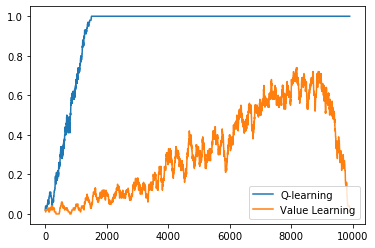

In [49]:
config = {
    "alpha": 0.1,
    "gamma": 0.99,
    "epsilon": 0.99,
    "iters": 10000, 
    "anneal": 1500
}

r_4x4 = standard_q_learning(fl_4x4, config)
rv_4x4 = value_iteration(fl_4x4, config)

plt.plot(smooth(r_4x4, 100), label="Q-learning")
plt.plot(smooth(rv_4x4, 100), label="Value Learning")
plt.legend()

In [47]:
fl_4x4.P[2][1]

[(0.3333333333333333, 1, 0.0, False),
 (0.3333333333333333, 6, 0.0, False),
 (0.3333333333333333, 3, 0.0, False)]